In [1]:
%load_ext pycodestyle_magic
%flake8_on
# PEP8 tested

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from itertools import product, combinations
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from functions import heatmap2
from umap import UMAP
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

7:80: E501 line too long (98 > 79 characters)
8:80: E501 line too long (92 > 79 characters)
1: E999 SyntaxError: invalid syntax


In [3]:
# be sure to display any columns
pd.options.display.max_columns = 100

# 1. Read data

In [4]:
# read data
time_start = time.time()
data = pd.read_csv('Data/data.csv')
print('data imported, elapsed time: {} seconds'.format(time.time()-time_start))

data imported, elapsed time: 1.3899269104003906 seconds


In [5]:
# index by customer_unique_id
data = data.rename(index=data['customer_unique_id'])

In [6]:
# type & nb of features
print(data.dtypes.unique())
print(data.columns.size)

[dtype('O') dtype('int64') dtype('float64')]
78


In [7]:
# track numerical features to keep those not to transform
data.select_dtypes(include='number').columns

Index(['order_purchase_year', 'order_purchase_month', 'order_purchase_day',
       'order_purchase_dayofweek', 'order_purchase_hour',
       'estimated_delivery_time', 'effective_delivery_time',
       'delivery_vs_estimated', 'total_price', 'total_freight',
       'freight_percentage', 'charm_price', 'product_price', 'product_freight',
       'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_size',
       'product_qlty_index', 'product_density', 'main_payment_value',
       'payment_sequence_size', 'payment_installments_size', 'payment_total',
       'seller_lat', 'seller_lng', 'order_count', 'customer_lat',
       'customer_lng', 'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_charm_price', 'product

In [8]:
# switch to dtype object for further data slicing
for i in ['order_purchase_year',
          'order_purchase_month']:
    data[i] = data[i].astype('object')

#### Define Raw Categorical & Raw Numercial features

In [9]:
# raw categorical features
# only '_cat' because levels '_lvl' are redundant with their numerical origin
raw_categorical_features = data.columns[data.columns.str.contains('_cat')]
len(raw_categorical_features)

7

In [10]:
# keep a raw cat df
data_raw_categorical = data.filter(raw_categorical_features)

In [11]:
# raw numerical features
raw_numerical_features = data.select_dtypes(include='number').columns
len(raw_numerical_features)

42

In [12]:
# keep a raw cat df
raw_data_numerical = data.filter(raw_numerical_features)

In [13]:
# Both num and cat features
raw_features_list = list(raw_categorical_features)
raw_features_list.extend(list(raw_numerical_features))
len(raw_features_list)

49

In [14]:
# projeter sur un df dédié
raw_data_filtered = data.filter(raw_features_list)
raw_data_filtered.shape

(87086, 49)

In [15]:
# sample (10%)
raw_data_sample = pd.DataFrame(raw_data_filtered).sample(
    int(data.shape[0]/10),
    random_state=42)
raw_data_sample.shape

(8708, 49)

# 2. Transform data

#### define transformer

In [16]:
# steps transform any feature by type
numerical_pipeline = Pipeline(
    steps=[
        ('rankgauss', QuantileTransformer(n_quantiles=100,
                                          random_state=111,
                                          output_distribution='normal')),
        ('scaler', StandardScaler())
    ]
)
categorical_pipeline = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('scaler', StandardScaler(with_mean=False))
    ]
)

In [17]:
# common raw transformer
myrawtransformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, raw_categorical_features),
        ('num', numerical_pipeline, raw_numerical_features)])

#### apply transfomer

In [18]:
# fit transformer
myrawtransformer.fit(raw_data_filtered)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['purchase_time_zone_cat', 'charmed_price_cat', 'product_cat',
       'payment_sequence_size_cat', 'payment_installment_size_cat',
       'main_payment_type_cat', 'seller_main_product_cat'],
      dtype='object')),
                                ('num',...
       'seller_lat', 'seller_lng', 'order_count', 'customer_lat',
       'customer_lng', 'cust_sell_dist', 'review_score', 'review_answer_delay',
       'product_review_count', 'product_review_mean', 'customer_review_count',
       'customer_review_mean', 'review_gap', 'seller_sales_count',
       'seller_revenue', 'mean_seller_product_price',
       'mean_seller_

In [19]:
# proceed to get the features names for column headers
encoder = OneHotEncoder()
encoder.fit(data[raw_categorical_features])
raw_categorical_labels = encoder.get_feature_names(raw_categorical_features)

In [20]:
# rebuild feature's list
raw_columns_names = list(raw_categorical_labels)
raw_columns_names.extend(list(raw_numerical_features))

In [21]:
# apply columns to the transformed DataFrame
raw_transformed_data = pd.DataFrame(myrawtransformer.transform(raw_data_filtered), columns=raw_columns_names)

In [22]:
# transformed still contains any data
raw_transformed_data.shape

(87086, 85)

#### Use case : case of a shortlist

In [23]:
# shortlist proposal keeping year month for further cuts
features_shortlist = ['cust_sell_dist',
                      'product_price',
                      'product_qlty_index',
                      'product_review_mean',
                      'review_gap',
                      'charmed_price_cat',
                      'purchase_time_zone_cat',
                      'order_purchase_year',
                      'order_purchase_month']

In [24]:
# for mixed type : shorten and go back to the columns definition
short_data_filtered = data.filter(features_shortlist)

In [25]:
# num & cat lists
short_categorical_features = short_data_filtered.columns[
    short_data_filtered.columns.str.contains('_cat')]
print(short_categorical_features)
short_numerical_features = short_data_filtered.select_dtypes(
    include='number').columns
print(short_numerical_features)

Index(['charmed_price_cat', 'purchase_time_zone_cat'], dtype='object')
Index(['cust_sell_dist', 'product_price', 'product_qlty_index',
       'product_review_mean', 'review_gap'],
      dtype='object')


In [26]:
# update transformer
# common short transformer
myshorttransformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, short_categorical_features),
        ('num', numerical_pipeline, short_numerical_features)])
myshorttransformer.fit(short_data_filtered)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('scaler',
                                                  StandardScaler(with_mean=False))]),
                                 Index(['charmed_price_cat', 'purchase_time_zone_cat'], dtype='object')),
                                ('num',
                                 Pipeline(steps=[('rankgauss',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=111)),
                                                 ('scaler', StandardScaler())]),
                                 Index(['cust_sell_dist', 'product_price', 'product_qlty_index',

In [27]:
# proceed to get the features names for column headers
encoder = OneHotEncoder()
encoder.fit(short_data_filtered[short_categorical_features])
short_categorical_labels = encoder.get_feature_names(short_categorical_features)

In [28]:
# rebuild feature's list
short_columns_names = list(short_categorical_labels)
short_columns_names.extend(list(short_numerical_features))

In [29]:
# apply columns to the transformed DataFrame
short_transformed_data = pd.DataFrame(myshorttransformer.transform(short_data_filtered), columns=short_columns_names)

In [30]:
# transformed still contains any data
short_transformed_data.shape

(87086, 12)

# 3. Reduce data dimension

#### define PCA reducer

In [31]:
# target a variance %
n_components = 0.8

In [32]:
# introduce PCA as dim reducer step into the pipeline
mydimreducer = Pipeline(
    [
        ('pca', PCA(n_components=n_components))
    ])


In [33]:
# chain transform & reduce
mypreprocessor = Pipeline(
    [
        ('transformer', myrawtransformer),
        ('reducer', mydimreducer)
    ])

#### apply PCA reducer

#### PCA to any features (both numerical and categorical)

In [34]:
# we can go back to entire dataset
raw_data_reduced_df = pd.DataFrame(mypreprocessor.fit_transform(raw_data_filtered))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio (up to 80%) \n- Any features -')

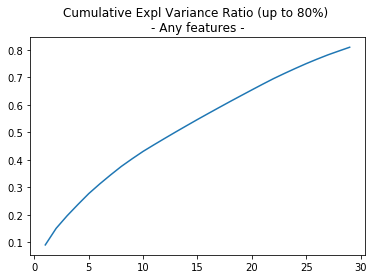

In [35]:
# cumulative expl variance ratio
plt.plot(np.array([i for i in range(1, raw_data_reduced_df.shape[1]+1)]),
         np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio (up to 80%) \n- Any features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Any features -')

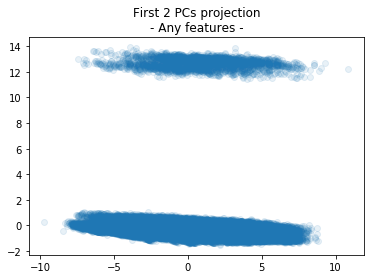

In [36]:
# data projection
plt.scatter(raw_data_reduced_df.iloc[:, 0],
            raw_data_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Any features -')

#### PCA to numerical features

In [37]:
# same for num only
raw_data_numerical_df = pd.DataFrame(
    myrawtransformer.fit_transform(raw_data_filtered),
    columns=raw_columns_names).filter(raw_numerical_features)

In [38]:
# apply reducer
raw_data_numerical_reduced_df = pd.DataFrame(mypreprocessor['reducer']['pca'].fit_transform(raw_data_numerical_df))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio (up to 80%) \n- Numerical features -')

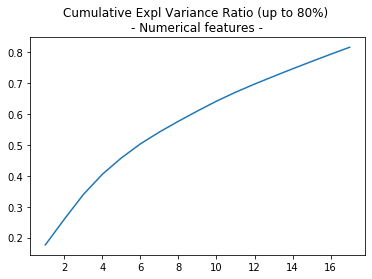

2:80: E501 line too long (83 > 79 characters)


In [39]:
# cumulative expl variance ratio
plt.plot(np.array([i for i in range(1, raw_data_numerical_reduced_df.shape[1]+1)]),
         np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio (up to 80%) \n- Numerical features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Numerical features -')

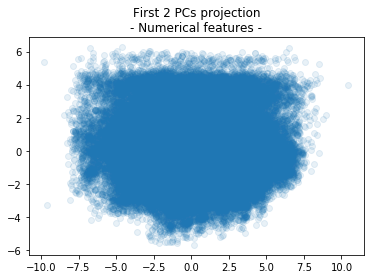

In [40]:
# projection
plt.scatter(raw_data_numerical_reduced_df.iloc[:, 0],
            raw_data_numerical_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Numerical features -')

#### PCA to categorical features

In [41]:
# same for catégorical
raw_data_categorical_df = pd.DataFrame(
    myrawtransformer.fit_transform(raw_data_filtered),
    columns=raw_columns_names).filter(list(raw_categorical_labels))

In [42]:
# reduce
raw_data_categorical_reduced_df = pd.DataFrame(mypreprocessor['reducer']['pca'].fit_transform(raw_data_categorical_df))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio (up to 80%) \n- Categorical features -')

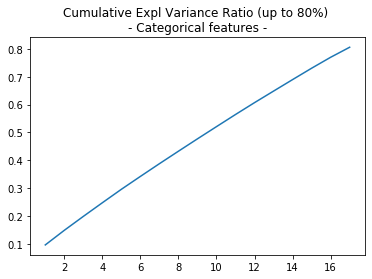

2:80: E501 line too long (85 > 79 characters)


In [43]:
# cumulative expl variance ratio
plt.plot(np.array([i for i in range(1, raw_data_categorical_reduced_df.shape[1]+1)]),
         np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio (up to 80%) \n- Categorical features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Categorical features -')

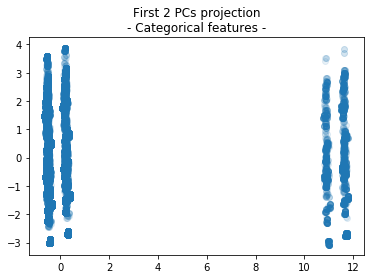

In [44]:
plt.scatter(raw_data_categorical_reduced_df.iloc[:, 0],
            raw_data_categorical_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Categorical features -')

#### use case : PCA to the shortlist

In [45]:
# chain transform & reduce for short list
myshortpreprocessor = Pipeline(
    [
        ('transformer', myshorttransformer),
        ('reducer', mydimreducer)
    ])

In [46]:
# PCA has the same set up (with 80 % of explained variance)
myshortpreprocessor['reducer']['pca'].n_components = 0.8

In [47]:
# apply mydimreducer only
short_transformed_data_reduced_df = pd.DataFrame(myshortpreprocessor['reducer']['pca'].fit_transform(short_transformed_data))

Text(0.5, 1.0, 'Cumulative Expl Variance Ratio (up to 80%) \n- Shortlisted features -')

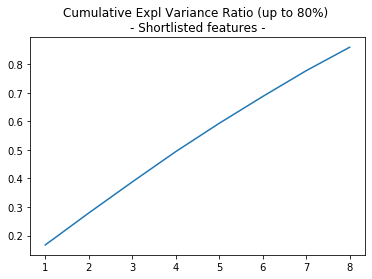

2:80: E501 line too long (87 > 79 characters)


In [48]:
# cumulative expl variance ratio
plt.plot(np.array([i for i in range(1, short_transformed_data_reduced_df.shape[1]+1)]),
         np.cumsum(mypreprocessor['reducer']['pca'].explained_variance_ratio_))
plt.title('Cumulative Expl Variance Ratio (up to 80%) \n- Shortlisted features -')

Text(0.5, 1.0, 'First 2 PCs projection\n- Shortlisted features -')

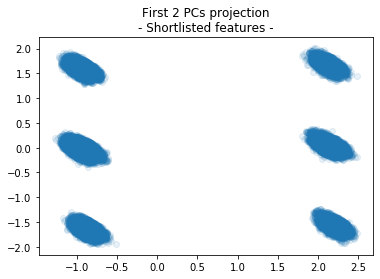

In [49]:
plt.scatter(short_transformed_data_reduced_df.iloc[:, 0],
            short_transformed_data_reduced_df.iloc[:, 1],
            alpha=.1)
plt.title('First 2 PCs projection\n- Shortlisted features -')

In [50]:
# features contribution to PCs
pca_coordinates = mypreprocessor['reducer']['pca'].components_

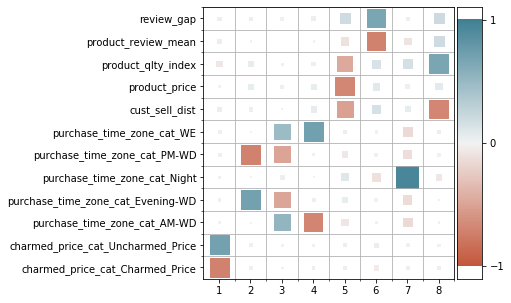

In [51]:
# display feature contributions along principal components
reduced = pd.DataFrame(pca_coordinates)
reduced.columns = short_transformed_data.columns
reduced = pd.melt(reduced.reset_index(), id_vars='index')
reduced.columns = ['x', 'y', 'value']
reduced['x'] = reduced['x'] + 1
heatmap2(
    x=reduced['x'],
    y=reduced['y'],
    size=reduced['value'].abs(),
    color=reduced['value'],
    a=5,
    b=5
)

# 4. Alternate dimension reducers

### 4.1. T-Distributed Stochastic Neighbouring Entities (t-SNE)

Hyperparameters for t-SNE 
n_jobs number_cpus 
perplexity controls number of nearest-neighbors, use value between 5 and 50
early_exaggeration=12.0,  For larger values, the space between natural clusters will be larger in the embedded space.
learning_rate=200.0,  too high or too low: all datapoints will be bunched together.

In [52]:
# sample (10%) due to complexity case of use case
short_transformed_data_sample = pd.DataFrame(short_transformed_data).sample(
    int(short_transformed_data.shape[0]/10),
    random_state=42)
short_transformed_data_sample.shape

(8708, 12)

In [53]:
# sample (10%) due to complexity case any features
raw_transformed_data_sample = pd.DataFrame(raw_transformed_data).sample(
    int(short_transformed_data.shape[0]/10),
    random_state=42)
raw_transformed_data_sample.shape

(8708, 85)

#### t-SNE to any features

In [54]:
# t-SNE on use case with perplexity tunning
time_start = time.time()
results_list = list()
tsne_results = []
for i in [5, 20, 35, 50, 65, 80]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=300)
    tsne_results = tsne.fit_transform(raw_transformed_data_sample)
    results_list.append(tsne_results)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.689s...
[t-SNE] Computed neighbors for 8708 samples in 17.450s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 1.906102
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.167114
[t-SNE] KL divergence after 300 iterations: 3.867590
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.424s...
[t-SNE] Computed nei

In [55]:
tsne_results_5 = results_list[0]
tsne_results_20 = results_list[1]
tsne_results_35 = results_list[2]
tsne_results_50 = results_list[3]
tsne_results_65 = results_list[4]
tsne_results_80 = results_list[5]

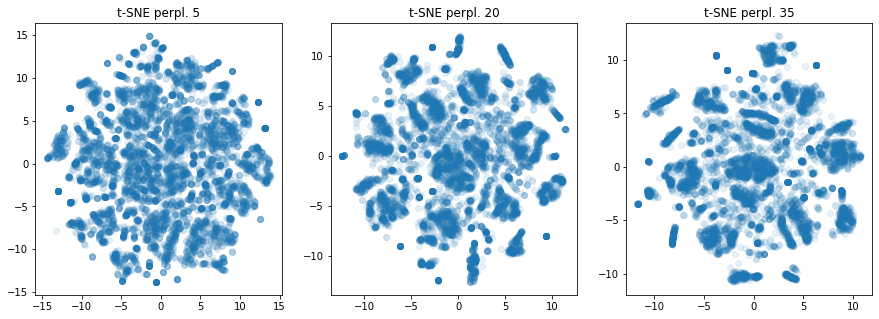

In [56]:
# display t-SNE results tuning perplexity
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5])
ax1.scatter(tsne_results_5[:, 0],
            tsne_results_5[:, 1],
            alpha=.1)
ax1.title.set_text('t-SNE perpl. 5')
ax2.scatter(tsne_results_20[:, 0],
            tsne_results_20[:, 1],
            alpha=.1)
ax2.title.set_text('t-SNE perpl. 20')
ax3.scatter(tsne_results_35[:, 0],
            tsne_results_35[:, 1],
            alpha=.1)
ax3.title.set_text('t-SNE perpl. 35')
plt.show()

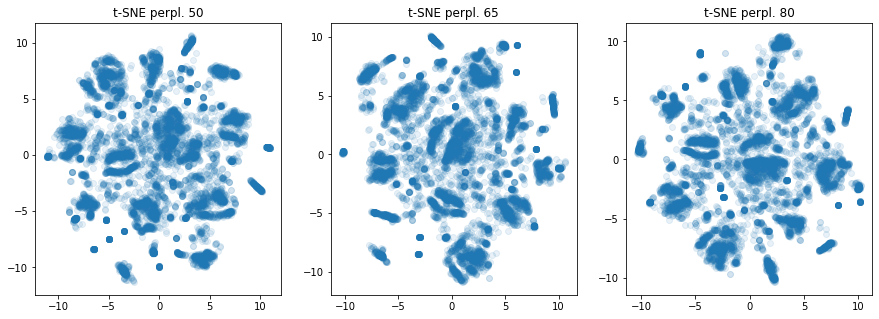

In [57]:
# display t-SNE results tuning perplexity
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15, 5])
ax1.scatter(tsne_results_50[:, 0],
            tsne_results_50[:, 1],
            alpha=.1)
ax1.title.set_text('t-SNE perpl. 50')
ax2.scatter(tsne_results_65[:, 0],
            tsne_results_65[:, 1],
            alpha=.1)
ax2.title.set_text('t-SNE perpl. 65')
ax3.scatter(tsne_results_80[:, 0],
            tsne_results_80[:, 1],
            alpha=.1)
ax3.title.set_text('t-SNE perpl. 80')
plt.show()

#### t-SNE to numerical features

In [58]:
raw_transformed_numerical_data_sample = raw_transformed_data_sample.filter(raw_numerical_features)

In [59]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
tsne_num_results = tsne.fit_transform(raw_transformed_numerical_data_sample)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.129s...
[t-SNE] Computed neighbors for 8708 samples in 10.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 1.960271
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.995445
[t-SNE] KL divergence after 300 iterations: 3.126292
t-SNE done! Time elapsed: 42.76444220542908 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Numerical features -')

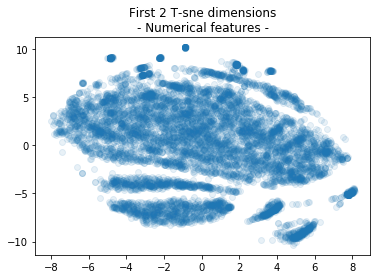

In [60]:
plt.scatter(tsne_num_results[:, 0],
            tsne_num_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Numerical features -')

#### t-SNE to categorical features

In [61]:
raw_transformed_categorcial_data_sample = raw_transformed_data_sample.filter(raw_categorical_labels)

In [62]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=300)
tsne_cat_results = tsne.fit_transform(raw_transformed_categorcial_data_sample)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.269s...
[t-SNE] Computed neighbors for 8708 samples in 5.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.688339
[t-SNE] KL divergence after 300 iterations: 1.745588
t-SNE done! Time elapsed: 26.723525285720825 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Categorical features -')

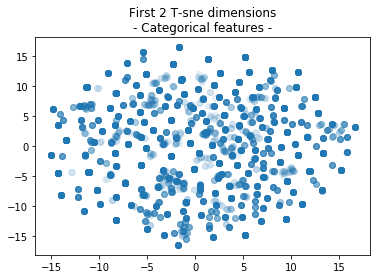

In [63]:
plt.scatter(tsne_cat_results[:, 0],
            tsne_cat_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Categorical features -')

#### t-SNE to features shortlist - Use Case 

In [64]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_short_results = tsne.fit_transform(short_transformed_data_sample)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8708 samples in 0.034s...
[t-SNE] Computed neighbors for 8708 samples in 1.924s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8708
[t-SNE] Computed conditional probabilities for sample 2000 / 8708
[t-SNE] Computed conditional probabilities for sample 3000 / 8708
[t-SNE] Computed conditional probabilities for sample 4000 / 8708
[t-SNE] Computed conditional probabilities for sample 5000 / 8708
[t-SNE] Computed conditional probabilities for sample 6000 / 8708
[t-SNE] Computed conditional probabilities for sample 7000 / 8708
[t-SNE] Computed conditional probabilities for sample 8000 / 8708
[t-SNE] Computed conditional probabilities for sample 8708 / 8708
[t-SNE] Mean sigma: 0.625118
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.452591
[t-SNE] KL divergence after 300 iterations: 2.426498
t-SNE done! Time elapsed: 25.702563285827637 seconds


Text(0.5, 1.0, 'First 2 T-sne dimensions\n- Use case features -')

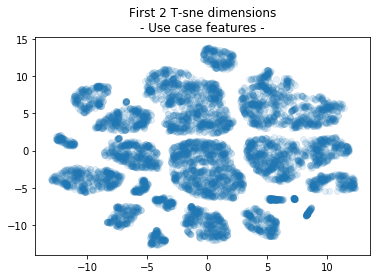

In [65]:
plt.scatter(tsne_short_results[:, 0],
            tsne_short_results[:, 1],
            alpha=.1)
plt.title('First 2 T-sne dimensions\n- Use case features -')

### 4.2. UMAP

UMAP's interest reside on its ability to "learn" the manifold structure of the data and preserve that topological structure within fewer dimensional space. <br/>
UMAP metric can be tuned according to data "type and shape", for instance hamming distance defined to handle binaries and that could better suit to our categorical data. <br/>
Furthermore UMAP paramters can be tuned according to a clustering perspective. <br/>
https://umap-learn.readthedocs.io/en/latest/parameters.html#


n_neighbors balances local (low n_neighbors) vs global structure (high); min_dist minimum distance apart that points are allowed to be in the representation. Use between 0 and 1 ; n_components=2, Number of final dimensions ;    metric="euclidean"  how distance is computed in the ambient space of the input data

In [66]:
projector_umap = UMAP(random_state=42,
                      n_neighbors=200,
                      min_dist=0.8,
                      n_components=2,
                      metric='manhattan')

In [67]:
time_start = time.time()
umap_short_results = projector_umap.fit_transform(short_transformed_data_sample)
print('umap done! Time elapsed: {} seconds'.format(time.time()-time_start))

2:80: E501 line too long (80 > 79 characters)


umap done! Time elapsed: 72.81617569923401 seconds


Text(0.5, 1.0, 'UMAP 2dim Manhattan 200n 0.8d \n - Use Case -')

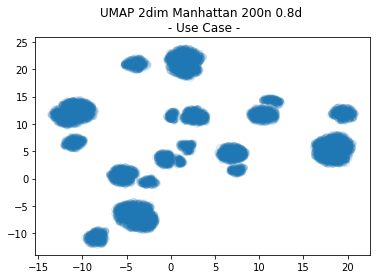

In [68]:
plt.scatter(umap_short_results[:, 0],
            umap_short_results[:, 1],
            alpha=.1)
plt.title('UMAP 2dim Manhattan 200n 0.8d \n - Use Case -')

# 5. Cluster data

## 5.1. K-Means

#### define clusterer

In [69]:
# clustering method step
kmeans_6k = KMeans(n_clusters=6)

In [70]:
short_transformed_data_reduced_df.shape

(87086, 8)

In [71]:
# silhouette score comparison with or without PCA
time_start = time.time()
# without PCA : short_transformed_data
kmeans_6k.fit(short_transformed_data)
kmeans_6k_labels = kmeans_6k.labels_
kmeans_6k_silhouette = silhouette_score(short_transformed_data, kmeans_6k_labels)
# with PCA : short_transformed_data_reduced_df
kmeans_6k.fit(short_transformed_data_reduced_df)
kmeans_6k_pca_labels = kmeans_6k.labels_
kmeans_6k_pca_silhouette = silhouette_score(short_transformed_data_reduced_df, kmeans_6k_pca_labels)
print('kmeans 6k with or without pca, elapsed time: {} seconds'.format(time.time()-time_start))

6:80: E501 line too long (81 > 79 characters)
10:80: E501 line too long (100 > 79 characters)


kmeans 6k with or without pca, elapsed time: 306.81391167640686 seconds


In [72]:
# results
print('kmeans_6k_silhouette : %f' % kmeans_6k_silhouette)
print('kmeans_6k_pca_silhouette : %f' % kmeans_6k_pca_silhouette)

kmeans_6k_silhouette : 0.257372
kmeans_6k_pca_silhouette : 0.326331


In [73]:
short_kmeans_6k_results = short_transformed_data_reduced_df.copy()

In [74]:
short_kmeans_6k_results['clusters'] = kmeans_6k_pca_labels

In [75]:
short_kmeans_6k_results.columns = ['PC1',
                                   'PC2',
                                   'PC3',
                                   'PC4',
                                   'PC5',
                                   'PC6',
                                   'PC7',
                                   'PC8',
                                   'clusters']
short_kmeans_6k_results['clusters'] = short_kmeans_6k_results['clusters'] + 1

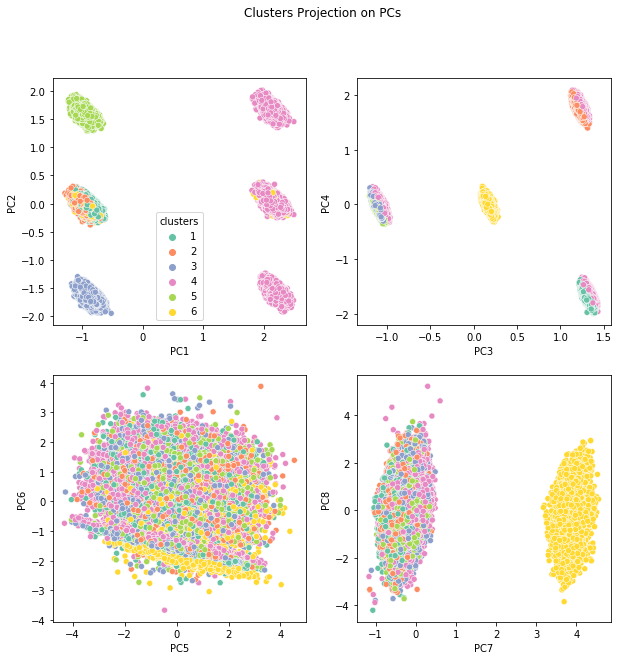

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Clusters Projection on PCs')

a = sns.scatterplot(ax=axes[0, 0],
                    x='PC1',
                    y='PC2',
                    hue='clusters',
                    palette='Set2',
                    data=short_kmeans_6k_results)
b = sns.scatterplot(ax=axes[0, 1],
                    x='PC3',
                    y='PC4',
                    hue='clusters',
                    palette='Set2',
                    data=short_kmeans_6k_results)
b.legend_.remove()
c = sns.scatterplot(ax=axes[1, 0],
                    x='PC5',
                    y='PC6',
                    hue='clusters',
                    palette='Set2',
                    data=short_kmeans_6k_results)
c.legend_.remove()
d = sns.scatterplot(ax=axes[1, 1],
                    x='PC7',
                    y='PC8',
                    hue='clusters',
                    palette='Set2',
                    data=short_kmeans_6k_results)
d.legend_.remove()


we get a better silhouette score after this PCA (80 % expl.variance)

## 5.2. Use Case : K-Means with same dim reduction (PCA 80%, 8 PCs)

In [77]:
short_transformed_data_reduced_df.shape

(87086, 8)

In [78]:
# empty scores list
kmeans_silhouette_scores = []
kmeans_davies_bouldin_score = []
sse = []

In [79]:
time_start = time.time()
for n in range(2, 10):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(short_transformed_data_reduced_df)
    kmeans_labels = kmeans.labels_
    kmeans_inertia = kmeans.inertia_
    kmeans_silhouette = silhouette_score(
        short_transformed_data_reduced_df,
        kmeans_labels)
    kmeans_davies_bouldin = davies_bouldin_score(
        short_transformed_data_reduced_df,
        kmeans_labels)

    # Add metrics to their lists
    kmeans_silhouette_scores.append(kmeans_silhouette)
    kmeans_davies_bouldin_score.append(kmeans_davies_bouldin)
    sse.append(kmeans_inertia)

print('kmeans k scan, silhouette computing, elapsed time: {} seconds'.format(time.time()-time_start))

kmeans k scan, silhouette computing, elapsed time: 1251.3724439144135 seconds


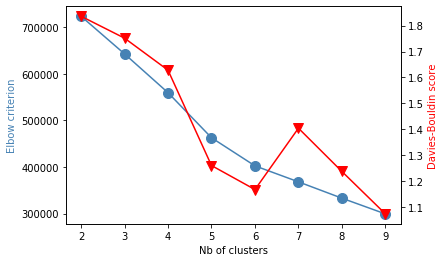

In [80]:
y = np.array([i for i in range(2, len(kmeans_davies_bouldin_score) + 2)])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(y,
         sse,
         'o-',
         markersize=10,
         color='steelblue')
ax2.plot(y,
         kmeans_davies_bouldin_score,
         'v-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

In [81]:
kmeans_labels

array([0, 0, 0, ..., 0, 2, 0])

## 5.3. K-Means tuning

#### tuning PCA n_components
introducing PCA metric explained_variance_ratio

In [82]:
# empty scores list
# kmeans_npca_silhouette_score = []
kmeans_npca_davies_bouldin_score = []
npca_explained_variance_ratios = []
# kmeans init (6 clusters)
kmeans_npca = KMeans(n_clusters=6)
time_start = time.time()
for n in range(2, short_transformed_data.shape[1]+1):
    # This set the number of PCA components,
    # but leaves other steps unchanged
    myshortpreprocessor['reducer']['pca'].n_components = n
    npca_short_transformed_data_reduced = pd.DataFrame(
        myshortpreprocessor['reducer']['pca'].fit_transform(
            short_transformed_data))
    npca_explained_variance = sum(
        myshortpreprocessor['reducer']['pca'].explained_variance_ratio_)
    kmeans_npca.fit(npca_short_transformed_data_reduced)
    kmeans_npca_labels = kmeans_npca.labels_

    # kmeans_npca_silhouette_score = silhouette_score(
    #    npca_short_transformed_data_reduced,
    #    kmeans_npca_labels)

    kmeans_pca_davies_bouldin = davies_bouldin_score(
        npca_short_transformed_data_reduced,
        kmeans_npca_labels)
    # Add metrics to their lists
    # kmeans_silhouette_scores.append(kmeans_npca_silhouette_score)
    kmeans_npca_davies_bouldin_score.append(kmeans_pca_davies_bouldin)
    npca_explained_variance_ratios.append(npca_explained_variance)
print('npca scan, elapsed time: {} seconds'.format(time.time()-time_start))

npca scan, elapsed time: 15.458563804626465 seconds


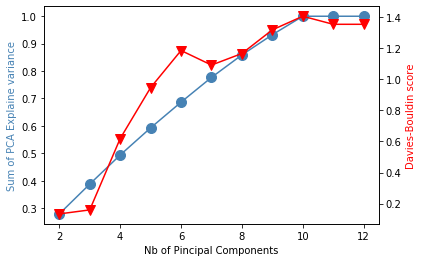

In [83]:
y = np.array([i for i in range(2, len(kmeans_npca_davies_bouldin_score) + 2)])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(y,
         npca_explained_variance_ratios,
         'o-',
         markersize=10,
         color='steelblue')
ax2.plot(y,
         kmeans_npca_davies_bouldin_score,
         'v-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of Pincipal Components')
ax1.set_ylabel('Sum of PCA Explaine variance', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

### nested loops to parse npca components and nclust clusters

In [84]:
# empty results
results = []
# kmeans_nested_silhouette_score = []
kmeans_nested_davies_bouldin_score = []
npca_nested_explained_variance_ratios = []
time_start = time.time()
for npca in range(2, short_transformed_data.shape[1]+1):
    # This set the number of PCA Components,
    myshortpreprocessor['reducer']['pca'].n_components = npca
    nested_short_transformed_data_reduced = pd.DataFrame(
        myshortpreprocessor['reducer']['pca'].fit_transform(
            short_transformed_data))
    npca_nested_explained_variance = sum(
        myshortpreprocessor['reducer']['pca'].explained_variance_ratio_)
    for nclust in range(2, 10):
        kmeans_nclust = KMeans(n_clusters=nclust)
        kmeans_nclust.fit(nested_short_transformed_data_reduced)
        kmeans_nclust_labels = kmeans_nclust.labels_
        # kmeans_nested_silhouette_score = silhouette_score(
        #    nested_short_transformed_data_reduced,
        #    kmeans_nclust_labels)
        kmeans_nested_davies_bouldin_score = davies_bouldin_score(
            nested_short_transformed_data_reduced,
            kmeans_nclust_labels)
        # Add metrics to their lists
        results.append({'npca': npca,
                        'nclust': nclust,
                         # 'kmeans_silhouette_score': kmeans_nested_silhouette_score,
                        'kmeans_davies_bouldin': kmeans_nested_davies_bouldin_score})
print('nested npca nclust scan, elapsed time: {} seconds'.format(time.time()-time_start))

nested npca nclust scan, elapsed time: 112.35232138633728 seconds


28:26: E127 continuation line over-indented for visual indent
28:80: E501 line too long (85 > 79 characters)
29:80: E501 line too long (85 > 79 characters)


In [85]:
df = pd.DataFrame(results)
print(df.iloc[df['kmeans_davies_bouldin'].idxmin()])

npca                     2.000000
nclust                   6.000000
kmeans_davies_bouldin    0.133328
Name: 4, dtype: float64


In [86]:
# get to 2 PCs pca to confirm how kmeans behave
myshortpreprocessor['reducer']['pca'].n_components = 2
pc2_short_data_reduced = pd.DataFrame(
    myshortpreprocessor['reducer']['pca'].fit_transform(
        short_transformed_data))
kmeans_6k_2pc = KMeans(n_clusters=6)
kmeans_6k_2pc.fit(pc2_short_data_reduced)
kmeans_6k_2pc_labels = kmeans_6k_2pc.labels_
kmeans_6k_2pc_silhouette = silhouette_score(
    pc2_short_data_reduced,
    kmeans_6k_2pc_labels)
print('kmeans_6k_2pc_silhouette : %f' % kmeans_6k_2pc_silhouette)

kmeans_6k_2pc_silhouette : 0.904481


In [87]:
# prepare plotting results
kmeans_6k_2pc_results = pc2_short_data_reduced.copy()
kmeans_6k_2pc_results['clusters'] = kmeans_6k_2pc_labels
kmeans_6k_2pc_results['clusters'] = kmeans_6k_2pc_results['clusters'] + 1
kmeans_6k_2pc_results.columns = ['PC1',
                                 'PC2',
                                 'clusters']

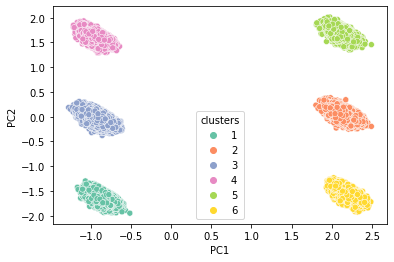

In [88]:
# 6 clusters for pca 2 components
fig.suptitle('6 Clusters Projection on PCA 2 components')
sns.scatterplot(x='PC1',
                y='PC2',
                hue='clusters',
                palette='Set2',
                data=kmeans_6k_2pc_results)

## 5.4. K-Means evaluation of alternate reducer t-SNE

In [ ]:
# get back tsne_short_results
tsne_short_sample = pd.DataFrame(tsne_short_results)
tsne_short_sample.shape

In [90]:
# empty scores list
# kmeans_tsen_silhouette_scores = []
kmeans_tsne_davies_bouldin_score = []
sse_tsne = []
time_start = time.time()
for n in range(2, 10):
    kmeans_tsne = KMeans(n_clusters=n)
    kmeans_tsne.fit(tsne_short_sample)
    kmeans_tsne_labels = kmeans_tsne.labels_
    kmeans_tsne_inertia = kmeans_tsne.inertia_
    # kmeans_silhouette = silhouette_score(tsne_short_sample, kmeans_labels)
    kmeans_tnse_davies_bouldin = davies_bouldin_score(
        tsne_short_sample,
        kmeans_tsne_labels)
    # Add metrics to their lists
    # kmeans_silhouette_scores.append(kmeans_silhouette)
    kmeans_tsne_davies_bouldin_score.append(kmeans_tnse_davies_bouldin)
    sse_tsne.append(kmeans_tsne_inertia)

print('kmeans k scan, with tsne 2 components, elapsed time: {} seconds'.format(time.time()-time_start))

kmeans k scan, with tsne 2 components, elapsed time: 2.2779974937438965 seconds


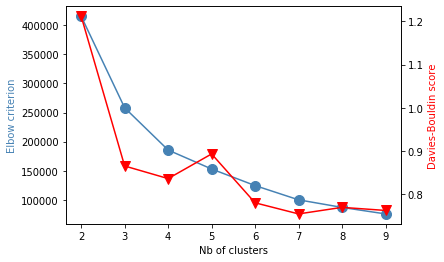

In [91]:
y = np.array([i for i in range(2, len(kmeans_tsne_davies_bouldin_score) + 2)])
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.grid(False)
ax2.grid(False)
ax1.plot(y,
         sse_tsne,
         'o-',
         markersize=10,
         color='steelblue')
ax2.plot(y,
         kmeans_tsne_davies_bouldin_score,
         'v-',
         markersize=10,
         color='red')
ax1.set_xlabel('Nb of clusters')
ax1.set_ylabel('Elbow criterion', color='steelblue')
ax2.set_ylabel('Davies-Bouldin score', color='red')
plt.show()

In [92]:
# silhouette score comparison with or without tsne
kmeans_4k = KMeans(n_clusters=4)
time_start = time.time()
# without tsne : short_transformed_data_sample
kmeans_4k.fit(short_transformed_data_sample)
kmeans_4k_labels = kmeans_4k.labels_
kmeans_4k_silhouette = silhouette_score(
    short_transformed_data_sample,
    kmeans_4k_labels)
# with tsne : tsne_short_sample
kmeans_4k.fit(tsne_short_sample)
kmeans_4k_tsne_labels = kmeans_4k.labels_
kmeans_4k_tsne_silhouette = silhouette_score(
    tsne_short_sample,
    kmeans_4k_tsne_labels)
print('kmeans 4k with or without tsne, elapsed time: {} seconds'.format(time.time()-time_start))

kmeans 4k with or without tsne, elapsed time: 3.8633716106414795 seconds


In [93]:
# results
print('kmeans_4k_silhouette : %f' % kmeans_4k_silhouette)
print('kmeans_4k_tsne_silhouette : %f' % kmeans_4k_tsne_silhouette)

kmeans_4k_silhouette : 0.241963
kmeans_4k_tsne_silhouette : 0.376905


In [94]:
# prepare plotting results
tsne_kmeans_4k_results = tsne_short_sample.copy()
tsne_kmeans_4k_results['clusters'] = kmeans_4k_tsne_labels
tsne_kmeans_4k_results['clusters'] = tsne_kmeans_4k_results['clusters'] + 1
tsne_kmeans_4k_results.columns = ['tsne 2d-one',
                                  'tsne 2d-two',
                                  'clusters']

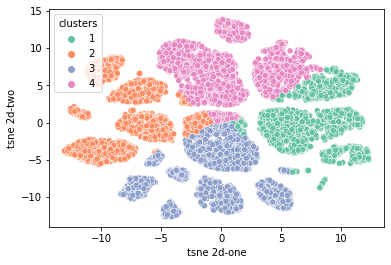

In [95]:
# 4 clusters for tsne
fig.suptitle('Clusters Projection on tsne 2d')
sns.scatterplot(x='tsne 2d-one',
                y='tsne 2d-two',
                hue='clusters',
                palette='Set2',
                data=tsne_kmeans_4k_results)

In [96]:
# get to 9 clusters to see how kmeans behave
kmeans_9k = KMeans(n_clusters=9)
kmeans_9k.fit(tsne_short_sample)
kmeans_9k_tsne_labels = kmeans_9k.labels_
kmeans_9k_tsne_silhouette = silhouette_score(
    tsne_short_sample,
    kmeans_9k_tsne_labels)
print('kmeans_9k_tsne_silhouette : %f' % kmeans_9k_tsne_silhouette)

kmeans_9k_tsne_silhouette : 0.404643


In [97]:
# prepare plotting results
tsne_kmeans_9k_results = tsne_short_sample.copy()
tsne_kmeans_9k_results['clusters'] = kmeans_9k_tsne_labels
tsne_kmeans_9k_results['clusters'] = tsne_kmeans_9k_results['clusters'] + 1
tsne_kmeans_9k_results.columns = ['tsne 2d-one',
                                  'tsne 2d-two',
                                  'clusters']

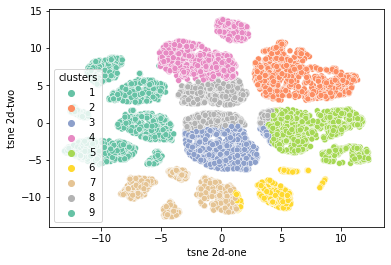

In [98]:
# 9 clusters for tsne
fig.suptitle('Clusters Projection on tsne 2d - 9 clusters')
sns.scatterplot(x='tsne 2d-one',
                y='tsne 2d-two',
                hue='clusters',
                palette='Set2',
                data=tsne_kmeans_9k_results)

# 6. Alternate clusterers

## 6.1. HDBSCAN
https://hdbscan.readthedocs.io/

#### HDBSCAN after PCA 80% 

In [99]:
# get back to pca data
short_transformed_data_reduced_df.shape

(87086, 8)

In [102]:
# sample
pca_short_sample = pd.DataFrame(short_transformed_data_reduced_df).sample(
    int(short_transformed_data_reduced_df.shape[0]/10),
    random_state=42)
pca_short_sample.shape

(8708, 8)

In [105]:
# initiate dbscan
dbscan = DBSCAN(eps=1.7, min_samples=10, metric='manhattan')

In [106]:
# perform clustering
dbscan.fit(pca_short_sample)
dbscan_labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# compute silhouette score
dbscan_labels_silhouette = silhouette_score(
    pca_short_sample,
    dbscan_labels)
print('dbscan_labels_silhouette : %f' % dbscan_labels_silhouette)

Estimated number of clusters: 10
Estimated number of noise points: 143
dbscan_labels_silhouette : 0.399960


In [108]:
# prepare plotting results
dbscan_results = pca_short_sample.copy()
dbscan_results['clusters'] = dbscan_labels

In [113]:
# remove noise points
dbscan_results = dbscan_results[dbscan_results['clusters'] != -1]

In [120]:
# rename columns
dbscan_results.columns = ['PC1',
                          'PC2',
                          'PC3',
                          'PC4',
                          'PC5',
                          'PC6',
                          'PC7',
                          'PC8',
                          'clusters']

In [121]:
# start from cluster 1
dbscan_results['clusters'] = dbscan_results['clusters'] + 1

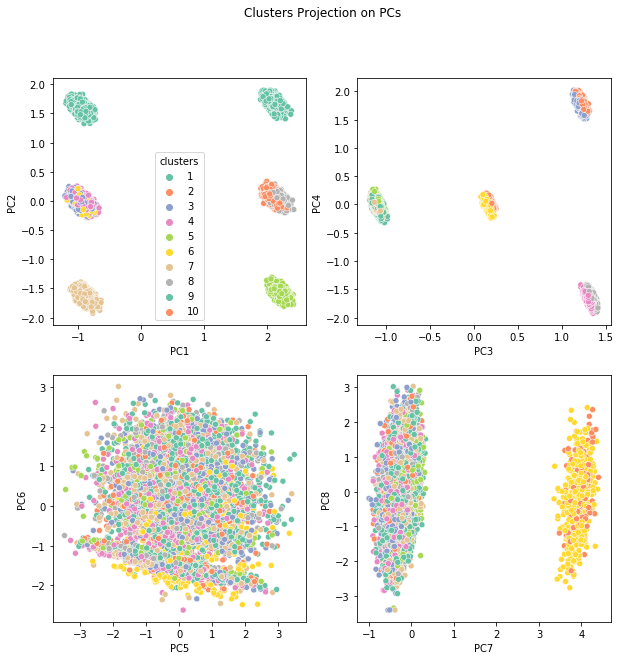

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Clusters Projection on PCs')

a = sns.scatterplot(ax=axes[0, 0],
                    x='PC1',
                    y='PC2',
                    hue='clusters',
                    palette='Set2',
                    data=dbscan_results)
b = sns.scatterplot(ax=axes[0, 1],
                    x='PC3',
                    y='PC4',
                    hue='clusters',
                    palette='Set2',
                    data=dbscan_results)
b.legend_.remove()
c = sns.scatterplot(ax=axes[1, 0],
                    x='PC5',
                    y='PC6',
                    hue='clusters',
                    palette='Set2',
                    data=dbscan_results)
c.legend_.remove()
d = sns.scatterplot(ax=axes[1, 1],
                    x='PC7',
                    y='PC8',
                    hue='clusters',
                    palette='Set2',
                    data=dbscan_results)
d.legend_.remove()


#### HDBSCAN after PCA 2 PCs

In [135]:
pc2_short_data_reduced.shape

(87086, 2)

In [136]:
# sample (10%)
pc2_short_data_sample = pd.DataFrame(pc2_short_data_reduced).sample(
    int(pc2_short_data_reduced.shape[0]/10),
    random_state=42)
pc2_short_data_sample.shape

(8708, 2)

In [137]:
# perform clustering
dbscan.fit(pc2_short_data_sample)
dbscan_pc2_labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_pc2_labels)) - (1 if -1 in dbscan_pc2_labels else 0)
n_noise_ = list(dbscan_pc2_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# compute silhouette score
dbscan_pc2_labels_silhouette = silhouette_score(
    pc2_short_data_sample,
    dbscan_pc2_labels)
print('dbscan_pc2_labels_silhouette : %f' % dbscan_pc2_labels_silhouette)

Estimated number of clusters: 2
Estimated number of noise points: 0


5:80: E501 line too long (81 > 79 characters)


dbscan_pc2_labels_silhouette : 0.634935


In [139]:
# prepare plotting results
dbscan_pc2_results = pc2_short_data_sample.copy()
dbscan_pc2_results['clusters'] = dbscan_pc2_labels

In [140]:
# remove noise points
dbscan_pc2_results = dbscan_pc2_results[dbscan_pc2_results['clusters'] != -1]

In [141]:
# rename columns
dbscan_pc2_results.columns = ['PC1',
                              'PC2',
                              'clusters']

In [142]:
# start from cluster 1
dbscan_pc2_results['clusters'] = dbscan_pc2_results['clusters'] + 1

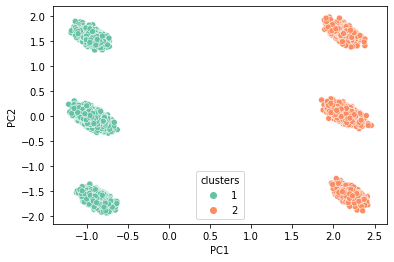

In [143]:
# 2 clusters with HDBSCAN for tsne
fig.suptitle('HDBSCAN Clusters Projection on pca 2 PCs - 2 clusters')
sns.scatterplot(x='PC1',
                y='PC2',
                hue='clusters',
                palette='Set2',
                data=dbscan_pc2_results)

#### HDBSCAN after t-SNE 2d transformation

In [100]:
tsne_short_sample.shape

(8708, 2)

In [124]:
# perform clustering
dbscan.fit(tsne_short_sample)
dbscan_tsne_labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_tsne_labels)) - (1 if -1 in dbscan_tsne_labels else 0)
n_noise_ = list(dbscan_tsne_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# compute silhouette score
dbscan_tsne_labels_silhouette = silhouette_score(
    tsne_short_sample,
    dbscan_tsne_labels)
print('dbscan_tsne_labels_silhouette : %f' % dbscan_tsne_labels_silhouette)

Estimated number of clusters: 11
Estimated number of noise points: 0


5:80: E501 line too long (83 > 79 characters)


dbscan_tsne_labels_silhouette : 0.006387


In [125]:
# prepare plotting results
dbscan_tsne_results = tsne_short_sample.copy()
dbscan_tsne_results['clusters'] = dbscan_tsne_labels

In [126]:
# remove noise points
dbscan_tsne_results = dbscan_tsne_results[dbscan_tsne_results['clusters'] != -1]

In [128]:
# rename columns
dbscan_tsne_results.columns = ['tsne-2d one',
                               'tsne-2d two',
                               'clusters']

In [129]:
# start from cluster 1
dbscan_tsne_results['clusters'] = dbscan_tsne_results['clusters'] + 1

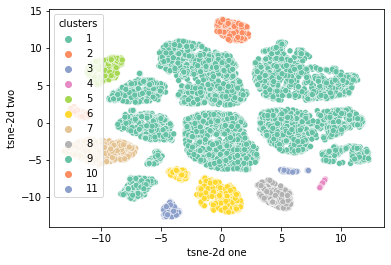

In [132]:
# 11 clusters with HDBSCAN for tsne
fig.suptitle('HDBSCAN Clusters Projection on tsne 2d - 11 clusters')
sns.scatterplot(x='tsne-2d one',
                y='tsne-2d two',
                hue='clusters',
                palette='Set2',
                data=dbscan_tsne_results)

#### HDBSCAN after no transformation

In [133]:
short_transformed_data_sample.shape

(8708, 12)

In [134]:
# perform clustering
dbscan.fit(short_transformed_data_sample)
dbscan_raw_labels = dbscan.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(dbscan_raw_labels)) - (1 if -1 in dbscan_raw_labels else 0)
n_noise_ = list(dbscan_raw_labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# compute silhouette score
dbscan_raw_labels_silhouette = silhouette_score(
    short_transformed_data_sample,
    dbscan_raw_labels)
print('dbscan_raw_labels_silhouette : %f' % dbscan_raw_labels_silhouette)

Estimated number of clusters: 20
Estimated number of noise points: 1765


5:80: E501 line too long (81 > 79 characters)


dbscan_raw_labels_silhouette : 0.130021


# 3. K-Modes & K-Prototypes

k-Modes intend to extend the k-Means algorithm, dedicated to categorical features : with discrete data as input (even with labels), it performs clustering that minimize a cost-function that measures a "matching dissimilarity". A cost unit is spent on any category switch. <br/>

Pros : 
- raw data (unpreprocessed) can be considered as inputs (even labels),
- it provides a clear cluster description, based on centroïd values,
- among the various init techniques (with pretty high dependency to init), 'Cao' research offers a deterministic approach introducing density of the data to their Modes (i.e. most frequent values). <br/>

Cons : 
this depends on the feature discretization in the first place, with <br/>
- cost approximation is wrong for ordinal features, i.e. cost is the same for any switch, even when passing from below_median to over_median (e.g. 1 to 3).
- while trying to find the best "k", the algorithm may reward the features with a 'k' corresponding discretization : e.g. the 5 levels of review scores would obviously lead to split into 5 clusters.<br/>


more details :
- https://www.sciencedirect.com/science/article/pii/S1319157818300065 <br/>
- https://medium.com/@davidmasse8/unsupervised-learning-for-categorical-data-dd7e497033ae <br/>

In [20]:
# https://github.com/nicodv/kmodes
from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

### Build a rough segmentation

In [13]:
# primary use case : get lvl & cat based on features_shortlist
features_shortlist

['cust_sell_dist',
 'product_price',
 'product_qlty_index',
 'product_review_mean',
 'review_gap',
 'charmed_price_cat',
 'purchase_time_zone_cat',
 'order_purchase_year',
 'order_purchase_month']

In [14]:
# features candidates for K-Modes : lvl & cat
print(data.columns[data.columns.str.contains('_lvl')])
print(data.columns[data.columns.str.contains('_cat')])

Index(['delivery_vs_estimated_lvl', 'freight_percentage_lvl',
       'product_qlty_index_lvl', 'payment_lvl', 'product_price_lvl',
       'cust_sell_dist_lvl', 'review_answer_delay_lvl',
       'product_review_mean_lvl', 'review_gap_lvl'],
      dtype='object')
Index(['purchase_time_zone_cat', 'charmed_price_cat', 'product_cat',
       'payment_sequence_size_cat', 'payment_installment_size_cat',
       'main_payment_type_cat', 'seller_main_product_cat'],
      dtype='object')


In [17]:
# shortlist lvl mapping (no need of month, year)
kmodes_shortlist = ['cust_sell_dist_lvl',
                    'product_price_lvl',
                    'product_qlty_index_lvl',
                    'product_review_mean_lvl',
                    'review_gap_lvl',
                    'charmed_price_cat',
                    'purchase_time_zone_cat']

In [221]:
data_kmodes = data.filter(kmodes_shortlist)
data_kmodes.shape

(87086, 7)

In [24]:
# get the data 'mode' with mono cluster : n_clusters = 1
# 'Cao' deterministic init computing feature modes
n_clusters = 1
km_test = KModes(n_clusters=n_clusters, init='Cao', n_init=1, verbose=1)
km_test.fit_predict(data_kmodes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 331681.0


array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

In [25]:
# centroids values
km_test.cluster_centroids_

array([['Near_Dist', 'Light_Price', 'High_QltyIdx', 'Low_Score',
        'Better_Review', 'Charmed_Price', 'PM-WD']], dtype='<U13')

In [30]:
mask = (data_kmodes['cust_sell_dist_lvl'] == 'Near_Dist') &\
    (data_kmodes['product_price_lvl'] == 'Light_Price') &\
    (data_kmodes['product_qlty_index_lvl'] == 'High_QltyIdx') &\
    (data_kmodes['product_review_mean_lvl'] == 'Low_Score') &\
    (data_kmodes['review_gap_lvl'] == 'Better_Review') &\
    (data_kmodes['charmed_price_cat'] == 'Charmed_Price') &\
    (data_kmodes['purchase_time_zone_cat'] == 'PM-WD')

In [31]:
print(data_kmodes[mask].shape)

(277, 7)


In [41]:
# cost as a function of n_clusters
time_start = time.time()
results_scan = []
for n_clusters in range(1, 10):
    kmode_scan = KModes(n_clusters=n_clusters, init="Cao", n_init=1, verbose=1)
    kmode_scan.fit_predict(data_kmodes)
    results_scan.append(kmode_scan.cost_)
print('kmodes k scan, elapsed time: {} seconds'.format(time.time()-time_start))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 331681.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 277108.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 249245.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 231980.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 224446.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 217536.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 210143.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, ite

Text(0.5, 1.0, 'cost values by clusters nb')

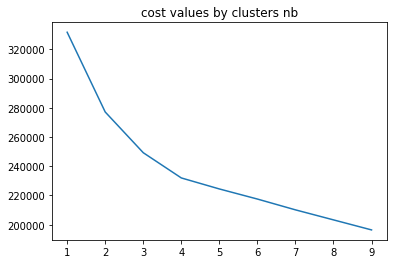

In [42]:
# costs decrease
y = np.array([i for i in range(1, 10)])
plt.plot(y, results_scan)
plt.title('cost values by clusters nb')

In [43]:
# let's see of what are made the 4 clusters
time_start = time.time()
n_clusters = 4
km_test = KModes(n_clusters=n_clusters, init='Cao', n_init=1, verbose=1)
km_test.fit_predict(data_kmodes)
print('kmodes single computation, elapsed time: {} seconds'.format(time.time()-time_start))
# centroids values
km_test.cluster_centroids_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 231980.0
kmodes single computation, elapsed time: 10.422129392623901 seconds


array([['Near_Dist', 'Light_Price', 'High_QltyIdx', 'Low_Score',
        'Better_Review', 'Charmed_Price', 'PM-WD'],
       ['Far_Dist', 'Medium_Price', 'Low_QltyIdx', 'Top_Score',
        'Same_Review', 'Charmed_Price', 'Evening-WD'],
       ['AroundMed_Dist', 'Light_Price', 'Low_QltyIdx', 'Medium_Score',
        'Worst_Review', 'Uncharmed_Price', 'AM-WD'],
       ['Far_Dist', 'Light_Price', 'Low_QltyIdx', 'Medium_Score',
        'Better_Review', 'Charmed_Price', 'WE']], dtype='<U15')

6:80: E501 line too long (91 > 79 characters)


In [44]:
# cluster balance & contents
data['kmodes_cluster'] = km_test.labels_

Text(0.5, 1.02, 'kmodes clusters size')

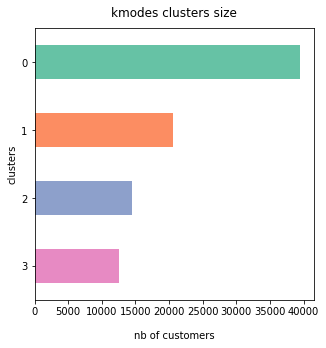

In [188]:
# clusters size
data['kmodes_cluster'].value_counts(sort=False).plot(
    kind='barh',
    color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'],
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('nb of customers', labelpad=14)
plt.ylabel('clusters')
plt.title('kmodes clusters size', y=1.02)

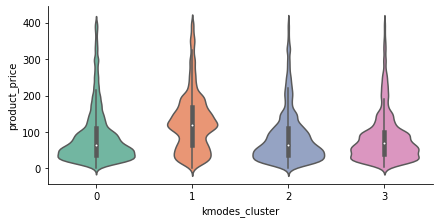

In [140]:
sns.catplot(x='kmodes_cluster',
            y='product_price',
            kind='violin',
            inner='box',
            palette='Set2',
            data=data[data['product_price'] <= 400],
            height=3,
            aspect=10/5)

In [112]:
# original features
cluster_features_display = ['cust_sell_dist',
                            'product_qlty_index',
                            'product_review_mean',
                            'review_gap']

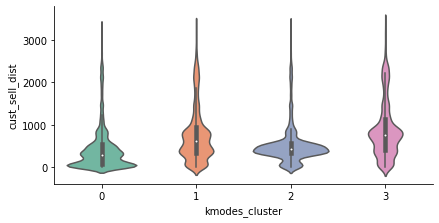

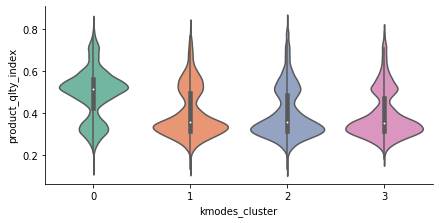

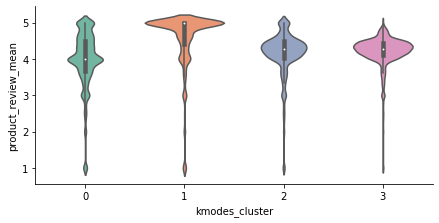

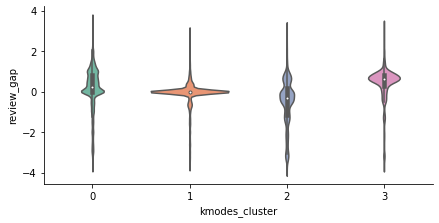

In [128]:
# visualiser les valeurs d'origine par cluster
for i in cluster_features_display:
    sns.catplot(x='kmodes_cluster',
                y=i,
                kind='violin',
                inner='box',
                palette='Set2',
                data=data,
                height=3,
                aspect=10/5)

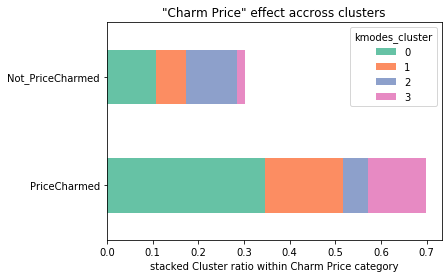

In [193]:
# Stacked barplot
charmed_ratio = data.loc[
    data['charmed_price_cat'] == 'Charmed_Price',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
uncharmed_ratio = data.loc[
    data['charmed_price_cat'] != 'Charmed_Price',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
df_charm = pd.DataFrame([charmed_ratio, uncharmed_ratio])
df_charm.index = ['PriceCharmed', 'Not_PriceCharmed']

# Plot
df_charm.plot(kind='barh',
              stacked=True,
              color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'],
              title='"Charm Price" effect accross clusters')
plt.xlabel('stacked Cluster ratio within Charm Price category')
plt.legend(title='kmodes_cluster')

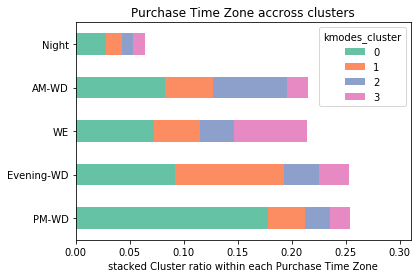

In [194]:
# Stacked barplot
PM_WD_ratio = data.loc[
    data['purchase_time_zone_cat'] == 'PM-WD',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
Evening_WD_ratio = data.loc[
    data['purchase_time_zone_cat'] == 'Evening-WD',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
WE_ratio = data.loc[
    data['purchase_time_zone_cat'] == 'WE',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
AM_WD_ratio = data.loc[
    data['purchase_time_zone_cat'] == 'AM-WD',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
Night_ratio = data.loc[
    data['purchase_time_zone_cat'] == 'Night',
    :]['kmodes_cluster'].value_counts()/data.shape[0]
df_zone = pd.DataFrame([PM_WD_ratio,
                        Evening_WD_ratio,
                        WE_ratio,
                        AM_WD_ratio,
                        Night_ratio])
df_zone.index = ['PM-WD', 'Evening-WD', 'WE', 'AM-WD', 'Night']

# Plot
df_zone.plot(kind='barh',
             stacked=True,
             color=['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3'],
             title='Purchase Time Zone accross clusters')
plt.xlim([0, 0.31])
plt.xlabel('stacked Cluster ratio within each Purchase Time Zone')
plt.legend(title='kmodes_cluster')

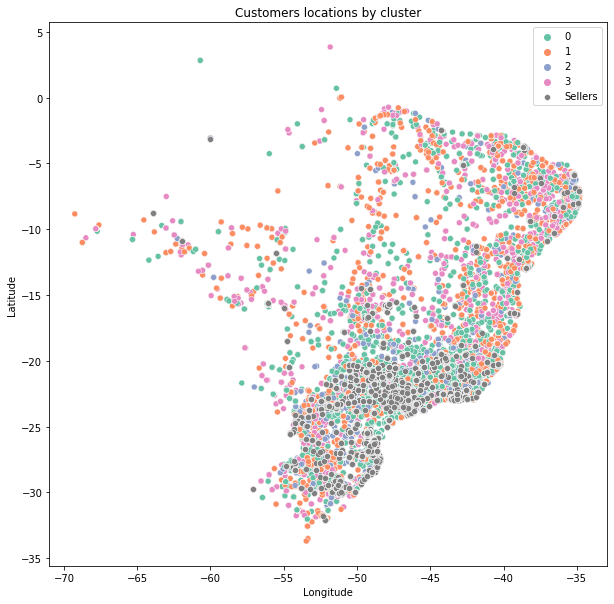

In [176]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                data=data,
                palette='Set2',
                hue='kmodes_cluster')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='grey',
                data=data,
                label='Sellers')
plt.title('Customers locations by cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Text(0.5, 1.0, 'Mean Price by Cluster')

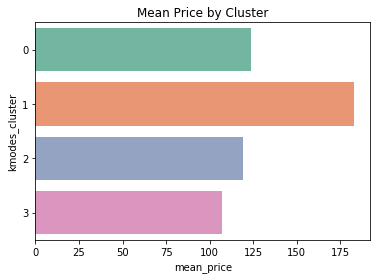

In [210]:
# mean sale price by clusters
df_sales_clusters = data.groupby(
    'kmodes_cluster',
    as_index=False).agg({'total_price': ['mean']})
df_sales_clusters.columns = ['kmodes_cluster',
                             'mean_price']

sns.barplot(y='kmodes_cluster',
            x='mean_price',
            data=df_sales_clusters,
            orient='h',
            palette='Set2').set_title('Mean Price by Cluster')

[Text(0, 0.5, 'Products Categories'),
 Text(0.5, 0, 'Sales Revenue'),
 Text(0.5, 1.0, 'Sales by Category for each Cluster')]

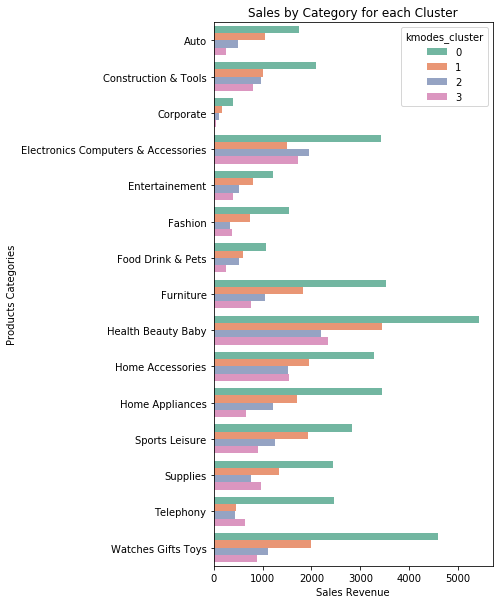

In [214]:
# répartition des ventes par catégorie de produit
df_sales_clust_categ = data.groupby(
    ['product_cat', 'kmodes_cluster'],
    as_index=False).agg({'order_id': ['count']})
df_sales_clust_categ.columns = ['product_cat',
                                'kmodes_cluster',
                                'count']
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(y='product_cat',
                 x='count',
                 hue='kmodes_cluster',
                 palette='Set2',
                 data=df_sales_clust_categ)
ax.set(xlabel='Sales Revenue',
       ylabel='Products Categories',
       title='Sales by Category for each Cluster')

### Assess stability

How different would be the cluster consider the two periods 2017 rise and 2018 stable?

In [227]:
data_rise = data[data['order_purchase_year'] == 2017]
data_rise_kmodes = data_rise.filter(kmodes_shortlist)
data_rise_kmodes.shape

(38731, 7)

In [228]:
data_stable = data[data['order_purchase_year'] == 2018]
data_stable_kmodes = data_stable.filter(kmodes_shortlist)
data_stable_kmodes.shape

(48352, 7)

In [237]:
# km_test init
n_clusters = 4
km_test = KModes(n_clusters=n_clusters, init='Cao', n_init=1, verbose=1)

In [238]:
# let's see of what are made the 4 clusters
time_start = time.time()
km_test.fit_predict(data_rise_kmodes)
print('kmodes two computation, elapsed time: {} seconds'.format(time.time()-time_start))
# centroids values
print(km_test.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 106439.0


4:80: E501 line too long (88 > 79 characters)


kmodes two computation, elapsed time: 5.187240123748779 seconds
[['Far_Dist' 'Light_Price' 'High_QltyIdx' 'Low_Score' 'Better_Review'
  'Charmed_Price' 'Evening-WD']
 ['AroundMed_Dist' 'Medium_Price' 'Low_QltyIdx' 'Medium_Score'
  'Same_Review' 'Charmed_Price' 'PM-WD']
 ['Near_Dist' 'Light_Price' 'Low_QltyIdx' 'Top_Score' 'Worst_Review'
  'Uncharmed_Price' 'WE']
 ['AroundMed_Dist' 'Light_Price' 'Low_QltyIdx' 'Top_Score'
  'Better_Review' 'Charmed_Price' 'AM-WD']]


In [239]:
# let's see of what are made the 4 clusters
time_start = time.time()
km_test.fit_predict(data_stable_kmodes)
print('kmodes two computation, elapsed time: {} seconds'.format(time.time()-time_start))
# centroids values
print(km_test.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 130819.0


4:80: E501 line too long (88 > 79 characters)


kmodes two computation, elapsed time: 5.93228816986084 seconds
[['Near_Dist' 'Light_Price' 'Low_QltyIdx' 'Top_Score' 'Better_Review'
  'Charmed_Price' 'PM-WD']
 ['AroundMed_Dist' 'Medium_Price' 'High_QltyIdx' 'Low_Score'
  'Same_Review' 'Uncharmed_Price' 'Evening-WD']
 ['Far_Dist' 'Light_Price' 'High_QltyIdx' 'Medium_Score' 'Worst_Review'
  'Charmed_Price' 'Evening-WD']
 ['AroundMed_Dist' 'Light_Price' 'High_QltyIdx' 'Low_Score'
  'Better_Review' 'Charmed_Price' 'AM-WD']]
